# Assignment 21

## Problem Statement

The affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. 

Use Logistic Regression to predict the classification for each women

## Description of Variables

### The dataset contains 6366 observations of 9 variables:

* rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
* age: woman's age
* yrs_married: number of years married
* children: number of children
* religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate     school, 20 = advanced degree)
* occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 =        teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)

* occupation_husb: husband's occupation (same coding as above)

* affairs: time spent in extra-marital affairs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from math import sqrt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# load dataset

df = sm.datasets.fair.load_pandas().data

In [3]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [4]:
# Add an "affair" column: 1 represents having affairs, 0 represents not

df['affair'] = (df.affairs > 0).astype(int)

In [5]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 10 columns):
rate_marriage      6366 non-null float64
age                6366 non-null float64
yrs_married        6366 non-null float64
children           6366 non-null float64
religious          6366 non-null float64
educ               6366 non-null float64
occupation         6366 non-null float64
occupation_husb    6366 non-null float64
affairs            6366 non-null float64
affair             6366 non-null int32
dtypes: float64(9), int32(1)
memory usage: 472.6 KB


## Exploratory Data Analysis

### Data Cleaning

In [7]:
# Since I created the Affair column based on the data in the Affairs column
# (if affairs > 0 then the woman had an affair else no) I am going to drop the affairs column

df.drop('affairs', axis=1, inplace=True)

In [8]:
# Count the number of null values in the columns
df.isnull().sum(axis=0)

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affair             0
dtype: int64

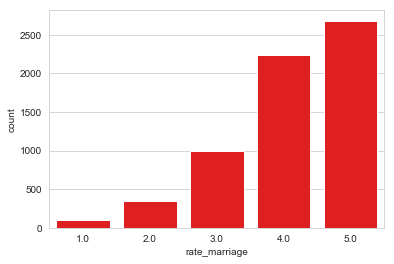

In [9]:
# See the distribution of Marriage Rate

sns.set_style('whitegrid')
sns.countplot(x='rate_marriage', data=df, color='red')

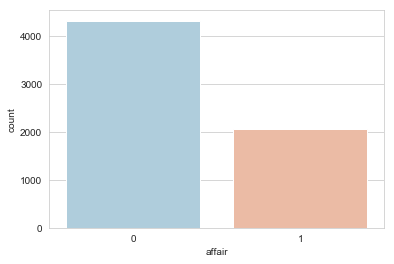

In [10]:
# Visualize the number of women who had affairs

sns.set_style('whitegrid')
sns.countplot(x='affair', data=df, palette='RdBu_r')

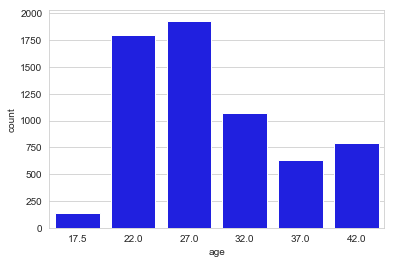

In [11]:
# See the distribution of Age for the dataset

sns.set_style('whitegrid')
sns.countplot(x='age', data=df, color='blue')

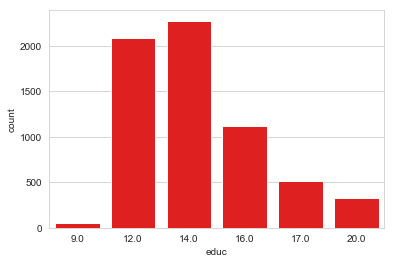

In [12]:
# See the distribution of education

sns.set_style('whitegrid')
sns.countplot(x='educ', data=df, color='red')

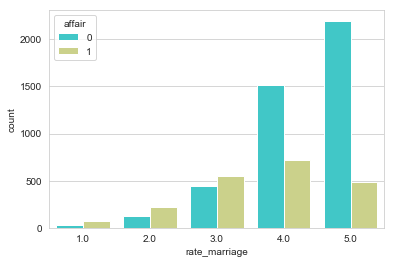

In [13]:
# Visualize how many had affairs based on marriage rate

sns.set_style('whitegrid')
sns.countplot(x='rate_marriage', hue='affair', data=df, palette='rainbow')

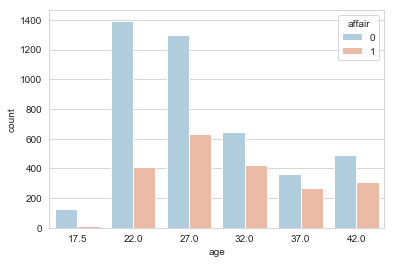

In [14]:
# Visualize how many had affairs based on age

sns.set_style('whitegrid')
sns.countplot(x='age', hue='affair', data=df, palette='RdBu_r')

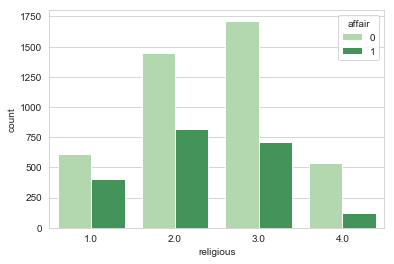

In [15]:
# Visualize how many had affairs based on religious preference

sns.set_style('whitegrid')
sns.countplot(x='religious', hue='affair', data=df, palette='Greens')

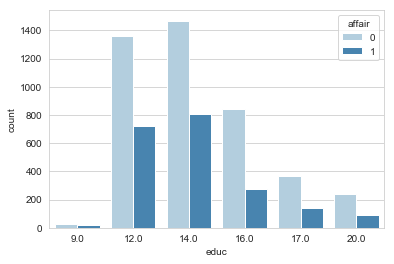

In [16]:
# Visualize how many had affairs based on level of education

sns.set_style('whitegrid')
sns.countplot(x='educ', hue='affair', data=df, palette='Blues')

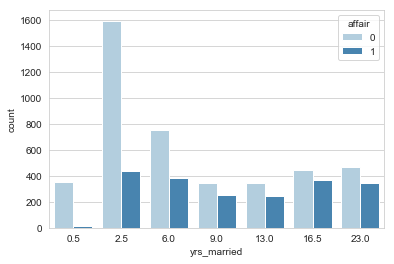

In [17]:
# Visualize how many had affairs based on number of years they were married

sns.set_style('whitegrid')
sns.countplot(x='yrs_married', hue='affair', data=df, palette='Blues')

# Building Logistic Regression Model

### Prepare the dataset

In [18]:
# We will convert wife's and husbands occupation to
# to dummy variable (LabelEncoding) and drop one column (OneHotEncoding)
# This will create a new dataframe for each feature

wife_occup = pd.get_dummies(df['occupation'],prefix='wife_occup_', drop_first=True)
husb_occup = pd.get_dummies(df['occupation_husb'], prefix='husb_occup_', drop_first=True)

In [19]:
wife_occup.head()

,wife_occup__2.0,wife_occup__3.0,wife_occup__4.0,wife_occup__5.0,wife_occup__6.0
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0


In [20]:
# I will drop the wife and husbands occupation columns from the dataset since I created the dummy variables

df.drop(['occupation', 'occupation_husb'], axis=1, inplace=True)

In [21]:
# I will concatenate the dummy variables to my dataset.

df = pd.concat([df,wife_occup,husb_occup], axis=1)

## Split the dataset into Training and Test set


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('affair', axis=1), df['affair'],
                                                    test_size = 0.30, random_state = 101)

In [59]:
# Print the shape of train and test data

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (4456, 26)
X_test:  (1910, 26)
y_train:  (4456,)
y_test:  (1910,)


## Create and Train the Logistic Regression Model

In [65]:
lrm = LogisticRegression()
lrm.fit(X_train, y_train)

C:\Users\KSamrari\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Make the predictions

In [66]:
y_pred = lrm.predict(X_test)

In [77]:
# Compare the Actual Overall Rating to the Predicted Overall Rating

ActualvsPred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [78]:
print(ActualvsPred.head(20))

      Actual  Predicted
2432       0          0
603        1          0
659        1          0
3632       0          0
582        1          1
2383       0          0
4883       0          0
6213       0          0
4711       0          0
5247       0          0
4974       0          0
1388       1          0
589        1          1
5279       0          0
2523       0          0
5071       0          0
2816       0          0
2486       0          0
4251       0          0
5201       0          0


In [71]:
# Look at the confusion matrix to see how our test data compares to the predicted data
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)

In [76]:
print(cm)

[[1159  118]
 [ 433  200]]


In [74]:
# Calculate the accuracy of our model.

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,y_pred)

In [75]:
print(accuracy)

0.7115183246073299


In [79]:
## Based on the accuracy of 0.7115, our model is 71% accurate at predicting if the women had affairs based on the given dataset